### Homework C - Transformer network for video frame prediction ###

Create dataset of microscopy images

In [1]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

c:\Users\jespe\anaconda3\envs\HW_C_env\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\jespe\anaconda3\envs\HW_C_env\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
c:\Users\jespe\anaconda3\envs\HW_C_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\jespe\anaconda3\envs\HW_C_env\lib\site-packages\

In [2]:
print(np.shape(dataset.resolve()))

(10, 64, 64, 1)


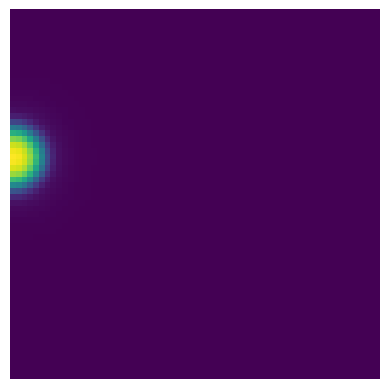

In [3]:
dataset.plot() # Plot first sequence

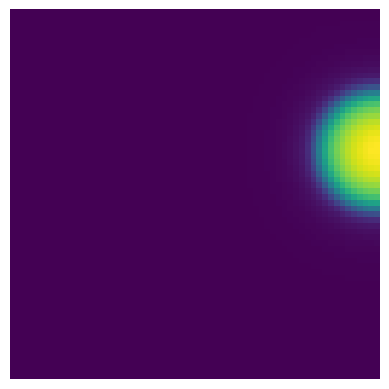

In [4]:
dataset.update().plot() # Plot updated sequence
video_sequence = dataset.update().resolve() # Get and store updated sequence

### Problem 1) Convolutional autoencoder ###

In [5]:
# Create dataset - training, validation and test
def create_dataset(train_len, val_len, test_len):
    train_data = []
    for i in range(train_len):
        train_data.extend(dataset.update().resolve())
    train_data = np.array(train_data)
    
    val_data = []
    for i in range(val_len):
        val_data.extend(dataset.update().resolve())
    val_data = np.array(val_data)
    
    test_data = []
    for i in range(test_len):
        test_data.extend(dataset.update().resolve())
    test_data = np.array(test_data)
    
    return train_data, val_data, test_data

train_data, val_data, test_data = create_dataset(train_len=2000, val_len=200, test_len=200)

In [6]:
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(20000, 64, 64, 1)
(2000, 64, 64, 1)
(2000, 64, 64, 1)


In [7]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64, 1)), 
            # Encoder
            layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2), # 64x64 -> 32x32
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), 
            layers.Flatten(), # 2D -> 1D
            layers.Dense(latent_dim, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(8*8*16, activation='relu'),
            layers.Reshape((8, 8, 16)), # 1D -> 2D
            
            # Decoder
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

latent_dim = 128 # dimensions of the vector representation fed to decoder from encoder
autoencoder = Autoencoder(latent_dim=latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.encoder.summary()
autoencoder.decoder.summary()       

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
Total params: 154,928
Trainable params: 154,928
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

Train the autoencoder 

In [8]:
autoencoder.fit(x=train_data, y=train_data, epochs=10, shuffle=True, validation_data=(val_data, val_data))

Epoch 1/10
625/625 [==============================] - 34s 53ms/step - loss: 1.3292 - val_loss: 0.2273
Epoch 2/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1595 - val_loss: 0.0940
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.0755 - val_loss: 0.0714
Epoch 4/10
625/625 [==============================] - 31s 50ms/step - loss: 0.0950 - val_loss: 0.0390
Epoch 5/10
625/625 [==============================] - 31s 49ms/step - loss: 0.0617 - val_loss: 0.0557
Epoch 6/10
625/625 [==============================] - 31s 50ms/step - loss: 0.0748 - val_loss: 0.0339
Epoch 7/10
625/625 [==============================] - 31s 50ms/step - loss: 0.0497 - val_loss: 0.0319
Epoch 8/10
625/625 [==============================] - 32s 51ms/step - loss: 0.0382 - val_loss: 0.0420
Epoch 9/10
625/625 [==============================] - 32s 50ms/step - loss: 0.0620 - val_loss: 0.0230
Epoch 10/10
625/625 [==============================] - 32s 51ms/step - loss: 0.027

Visualize results

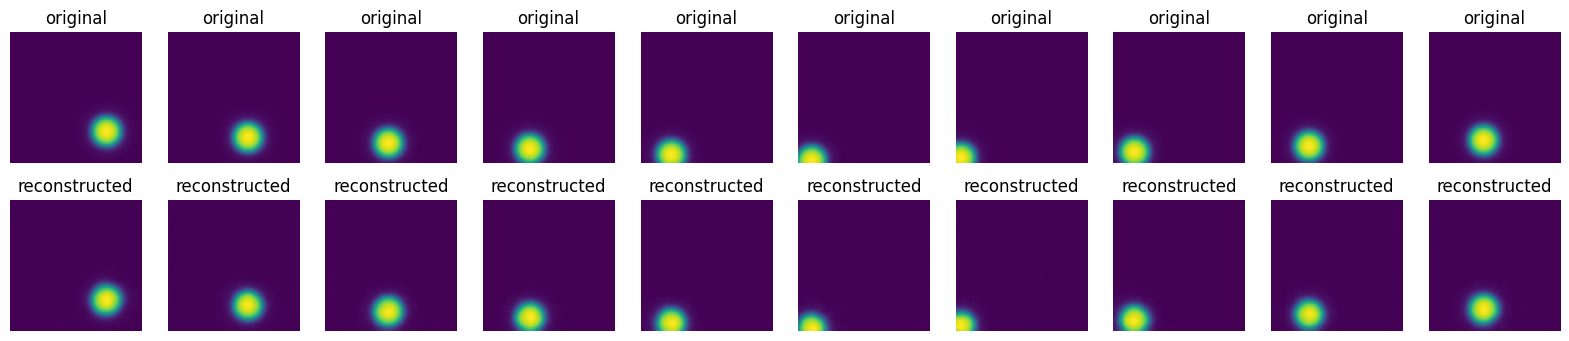

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

encoded_images = autoencoder.encoder(test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images): # plot original and reconstructed images for first sequence    
    ax = plt.subplot(2, n_images, i + 1) # original images
    plt.title("original")
    plt.imshow(tf.squeeze(test_data[i]))
    plt.axis("off")
    
    bx = plt.subplot(2, n_images, i+n_images+1) # reconstructed images
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_images[i]))
    plt.axis("off")
plt.show()

### Problem 2) Transformer encoder ###

Create dataset

In [10]:
create_dataset = False
train_len = int(1e4)
val_len = int(1e3)

if create_dataset:
  train_pictures = []
  for i in range(train_len):
    train_pictures.extend(dataset.update().resolve())
  train_pictures = np.array(train_pictures).reshape(train_len, 10, 64, 64, 1) 
  train_pictures.tofile('train_pictures.csv', sep=',')

  val_pictures = []
  for i in range(val_len):
    val_pictures.extend(dataset.update().resolve())
  val_pictures = np.array(val_pictures).reshape(val_len, 10, 64, 64, 1)  
  val_pictures.tofile('val_pictures.csv', sep=',')

In [11]:
# Read in dataset
if not create_dataset:
    train_pictures = np.fromfile('train_pictures.csv', sep=',').reshape(train_len, 10, 64, 64, 1)
    val_pictures = np.fromfile('val_pictures.csv', sep=',').reshape(val_len, 10, 64, 64, 1)

In [12]:
# The aim is to train frame prediction, so we remove tenth frame from each sequence
train_frames, train_targets = tf.split(train_pictures, [9, 1], axis=1)
val_frames, val_targets = tf.split(val_pictures, [9, 1], axis=1)

# encode the frames using the encoder part of the autoencoder
train_sequences = []
for i in range(train_len):
  train_sequences.append(autoencoder.encoder(train_frames[i]))
train_sequences = np.array(train_sequences)
  
val_sequences = []
for i in range(val_len):
  val_sequences.append(autoencoder.encoder(val_frames[i]))
val_sequences = np.array(val_sequences)

# Verify data shapes
print("Train frames shape:", train_frames.shape)
print("Train targets shape:", train_targets.shape)
print("Train sequences shape:", train_sequences.shape)
print()
print("Val frames shape:", val_frames.shape)
print("Val targets shape:", val_targets.shape)
print("Val sequences shape:", val_sequences.shape)

Train frames shape: (10000, 9, 64, 64, 1)
Train targets shape: (10000, 1, 64, 64, 1)
Train sequences shape: (10000, 9, 128)

Val frames shape: (1000, 9, 64, 64, 1)
Val targets shape: (1000, 1, 64, 64, 1)
Val sequences shape: (1000, 9, 128)


Construct time embedding layer

In [13]:
Layer = tf.keras.layers.Layer

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        
    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                                shape = (int(self.seq_len),),
                                                initializer = 'uniform',
                                                trainable = True)
        
        self.bias_linear = self.add_weight(name='bias_linear',
                                            shape = (int(self.seq_len),),
                                            initializer = 'uniform',
                                            trainable = True)
        
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape = (int(self.seq_len),),
                                                initializer = 'uniform',
                                                trainable = True)
        
        self.bias_periodic = self.add_weight(name='bias_periodic',
                                                shape = (int(self.seq_len),),
                                                initializer = 'uniform',
                                                trainable = True)
        
    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 64, 64, 1) to (batch, seq_len, 64, 64)
        time_linear = self.weights_linear * x + self.bias_linear # Linear part of the model
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension for concatenation
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic) # Periodic part of the model
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension for concatenation
        
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 64, 64, 2)
            

Construct Transformer encoder with multi-head attention -- SAVED

In [14]:
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Conv1D, Dense

class TransformerEncoder(Layer):
    def __init__(self, head_dim, n_heads, ff_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.d_k = self.d_v = head_dim
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.attn = MultiHeadAttention(num_heads=self.n_heads, key_dim=self.d_k,
                                        value_dim=self.d_v, dropout=self.dropout_rate)
        
        self.dropout = Dropout(self.dropout_rate)
        self.norm = LayerNormalization(epsilon=1e-6)
        
        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu') 
        
        self.ff_dense_1 = Dense(self.ff_dim, activation='relu')
        self.ff_dense_2 = Dense(self.ff_dim, activation='relu')
        
    def call(self, inputs):
        attn = self.attn(inputs, inputs, inputs)
        attn = self.dropout(attn)
        attn = self.norm(inputs + attn)
        
        ff = self.ff_conv1D_1(attn)
        ff = self.dropout(ff)
        ff = self.ff_conv1D_2(ff)
        ff = self.dropout(ff)
        
        ff = self.ff_dense_1(ff)
        ff = self.dropout(ff)
        ff = self.ff_dense_2(ff)
        ff = self.norm(inputs + ff)
        
        return ff

Create transformer network -- SAVED

In [16]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D, Dense

# Do not train the decoder
autoencoder.decoder.trainable = False

seq_len = 9 
head_dim = latent_dim + 2
ff_dim = latent_dim + 2
n_heads = 12
dropout_rate = 0.2

def create_model(latent_dim):

    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    attn_layer2 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    attn_layer3 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    
    input_seq = Input(shape=(seq_len, latent_dim))
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = attn_layer1(x)
    x = attn_layer2(x)
    x = attn_layer3(x)
    x = GlobalAveragePooling1D()(x)
    
    x = Dropout(dropout_rate)(x)
    x = Dense(latent_dim, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(latent_dim, activation='relu')(x)
    out = autoencoder.decoder(x)
    
    model = Model(inputs=input_seq, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model


model = create_model(latent_dim)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 9, 128)]     0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 9, 2)         36          ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 9, 130)       0           ['input_4[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_3 (Transfo  (None, 9, 130)      884390      ['concatenate_1[0][0]']    

In [17]:
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Conv1D, Dense

class TransformerEncoder(Layer):
    def __init__(self, head_dim, n_heads, ff_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.d_k = self.d_v = head_dim
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.attn = MultiHeadAttention(num_heads=self.n_heads, key_dim=self.d_k,
                                        value_dim=self.d_v, dropout=self.dropout_rate)
        
        self.dropout = Dropout(self.dropout_rate)
        self.norm = LayerNormalization(epsilon=1e-6)
        
        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')       
        self.ff_dense_1 = Dense(self.ff_dim, activation='relu')
        
    def call(self, inputs):
        attn = self.attn(inputs, inputs, inputs)
        attn = self.dropout(attn)
        attn = self.norm(inputs + attn)
        
        ff = self.ff_conv1D_1(attn)
        ff = self.dropout(ff)
        ff = self.ff_conv1D_2(ff)
        ff = self.dropout(ff)
        ff = self.ff_dense_1(ff)
        ff = self.norm(inputs + ff)
        
        return ff

In [20]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D, Dense

# Do not train the decoder
autoencoder.decoder.trainable = False

seq_len = 9 
head_dim = latent_dim + 2
ff_dim = latent_dim + 2
n_heads = 12
dropout_rate = 0.5

def create_model(latent_dim):

    time_embedding = Time2Vector(seq_len)
    dropout = Dropout(dropout_rate)
    attn_layer1 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    attn_layer2 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    
    dense_layer1 = Dense(latent_dim, activation='relu')
    dense_layer2 = Dense(latent_dim, activation='linear')
    
    input_seq = Input(shape=(seq_len, latent_dim))
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = attn_layer1(x)
    x = attn_layer2(x)
    x = GlobalAveragePooling1D()(x)
    
    x = dropout(x)
    x = dense_layer1(x)
    x = dropout(x)
    x = dense_layer2(x)
    out = autoencoder.decoder(x)
    
    model = Model(inputs=input_seq, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model


model = create_model(latent_dim)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 9, 128)]     0           []                               
                                                                                                  
 time2_vector_4 (Time2Vector)   (None, 9, 2)         36          ['input_7[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 9, 130)       0           ['input_7[0][0]',                
                                                                  'time2_vector_4[0][0]']         
                                                                                                  
 transformer_encoder_10 (Transf  (None, 9, 130)      867360      ['concatenate_4[0][0]']    

Train the model

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_sequences, train_targets, epochs=30, validation_data=(val_sequences, val_targets),
          shuffle = True, callbacks = callback)

Epoch 1/30
313/313 [==============================] - 21s 62ms/step - loss: 18.1880 - val_loss: 18.4422
Epoch 2/30
313/313 [==============================] - 20s 63ms/step - loss: 17.5042 - val_loss: 17.6326
Epoch 3/30
313/313 [==============================] - 21s 66ms/step - loss: 17.1249 - val_loss: 16.6919
Epoch 4/30
313/313 [==============================] - 21s 67ms/step - loss: 16.0162 - val_loss: 15.4615
Epoch 5/30
313/313 [==============================] - 21s 66ms/step - loss: 15.3628 - val_loss: 15.1424
Epoch 6/30
313/313 [==============================] - 20s 63ms/step - loss: 15.0108 - val_loss: 14.7052
Epoch 7/30
313/313 [==============================] - 20s 64ms/step - loss: 14.7965 - val_loss: 14.5657
Epoch 8/30
313/313 [==============================] - 20s 64ms/step - loss: 14.6675 - val_loss: 14.5027
Epoch 9/30
313/313 [==============================] - 20s 63ms/step - loss: 14.6317 - val_loss: 14.5663
Epoch 10/30
313/313 [==============================] - 20s 64ms/

Test prediction ability

1/1 [==============================] - 0s 11ms/step


(-0.5, 63.5, 63.5, -0.5)

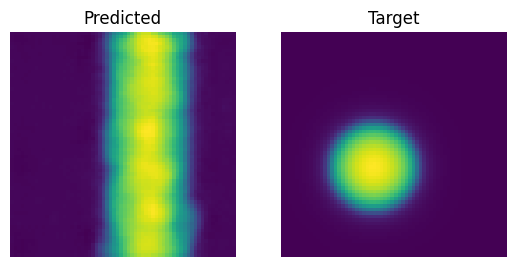

In [30]:
# Generate test sequence
test_sequence = []
for i in range(1):
    test_sequence.append(np.array(dataset.update().resolve()))
test_sequence = np.array(test_sequence)
test_frames, test_targets = tf.split(test_sequence, [9, 1], axis=1)

test_frames_enc = np.array([autoencoder.encoder(frame) for frame in test_frames])
# Feed the 9 test frames to the model
test_pred = model.predict(test_frames_enc)

pred_frame = test_pred[0]
target_frame = tf.squeeze(test_targets[0], axis=0)

# compare sequences 


# compare the predicted frame to the target
plt.subplot(1, 2, 1)
plt.imshow(pred_frame)
plt.title("Predicted")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(target_frame)
plt.title("Target")
plt.axis("off")

Create a RNN to compare against

In [33]:
from tensorflow.keras.layers import LSTM

# Do not train the decoder
autoencoder.decoder.trainable = False

seq_len = 9 
dropout_rate = 0.5

def create_model(latent_dim):

    time_embedding = Time2Vector(seq_len)
    dropout = Dropout(dropout_rate)
    LSTM_layer1 = LSTM(latent_dim, return_sequences=True, activation='relu') # return the whole sequence for the first LSTM layer
    LSTM_layer2 = LSTM(latent_dim, return_sequences=False, activation='relu') # return only the last output for last LSTM layer
    
    dense_layer1 = Dense(latent_dim, activation='relu')
    dense_layer2 = Dense(latent_dim, activation='linear')
    
    input_seq = Input(shape=(seq_len, latent_dim))
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = LSTM_layer1(x)
    x = LSTM_layer2(x)
    
    x = dropout(x)
    x = dense_layer1(x)
    x = Dropout(dropout_rate)(x)
    x = dropout(x)
    out = autoencoder.decoder(x)
    
    model = Model(inputs=input_seq, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model


model = create_model(latent_dim)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 9, 128)]     0           []                               
                                                                                                  
 time2_vector_8 (Time2Vector)   (None, 9, 2)         36          ['input_11[0][0]']               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 9, 130)       0           ['input_11[0][0]',               
                                                                  'time2_vector_8[0][0]']         
                                                                                                  
 lstm_6 (LSTM)                  (None, 9, 128)       132608      ['concatenate_8[0][0]']    

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_sequences, train_targets, epochs=30, validation_data=(val_sequences, val_targets),
          shuffle = True, callbacks = callback)

Epoch 1/30
313/313 [==============================] - 18s 52ms/step - loss: 19.9111 - val_loss: 19.7946
Epoch 2/30
313/313 [==============================] - 14s 46ms/step - loss: 18.3254 - val_loss: 17.9905
Epoch 3/30
313/313 [==============================] - 14s 45ms/step - loss: 17.6386 - val_loss: 17.0953
Epoch 4/30
313/313 [==============================] - 14s 45ms/step - loss: 17.4066 - val_loss: 17.1195
Epoch 5/30
313/313 [==============================] - 14s 45ms/step - loss: 17.3015 - val_loss: 16.7253
Epoch 6/30
313/313 [==============================] - 16s 51ms/step - loss: 17.1852 - val_loss: 16.8472
Epoch 7/30
313/313 [==============================] - 16s 51ms/step - loss: 17.1156 - val_loss: 16.7795
Epoch 8/30
313/313 [==============================] - 14s 46ms/step - loss: 17.0548 - val_loss: 16.9331


1/1 [==============================] - 0s 12ms/step


(-0.5, 63.5, 63.5, -0.5)

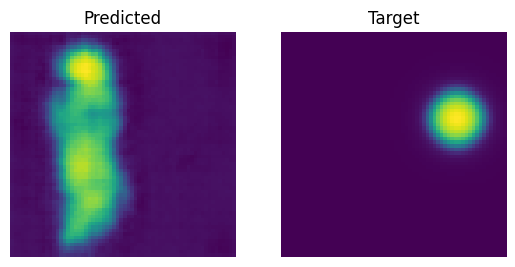

In [52]:
# Generate test sequence
test_sequence = []
for i in range(1):
    test_sequence.append(np.array(dataset.update().resolve()))
test_sequence = np.array(test_sequence)
test_frames, test_targets = tf.split(test_sequence, [9, 1], axis=1)

test_frames_enc = np.array([autoencoder.encoder(frame) for frame in test_frames])
# Feed the 9 test frames to the model
test_pred = model.predict(test_frames_enc)

pred_frame = test_pred[0]
target_frame = tf.squeeze(test_targets[0], axis=0)

# compare sequences 


# compare the predicted frame to the target
plt.subplot(1, 2, 1)
plt.imshow(pred_frame)
plt.title("Predicted")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(target_frame)
plt.title("Target")
plt.axis("off")